# Modelagem acústica via diferenças finitas

*   PET - Física UFRN
*   Petiano : Matheus Felipe Freitas Tomaz
*   Data : 26 de Junho de 2023

No `Notebook` [Interpolação de um dado sísmico - Método MPFI](https://github.com/MathPhelip/PET.py/blob/main/Notebooks/Interpola%C3%A7%C3%A3o%20de%20um%20dado%20s%C3%ADsmico.ipynb) haviamos discutido sobre interpolação de dado sísmico usando o MPFI, e no mesmo citamos que estavamos trabalhando com um dado sísmico sintético. Na Geofísica, é comum a modelagem de dados artificiais que simulem a realidade para o teste de interpolação, FWI etc, uma vez que dados reais demoram bastante para serem levantados. A ideia desse Notebook é apresentar o básico da ideia de modelagem, simulando uma propagação acústica usando o MDF (método das diferenças finitas).

Esse Notebook está divido nas sequintes seções :

*   **Introdução sobre o método sísmico**
*   **Física da propagação da onda acústica**
*   **Implementação Computacional** 
*   **Conclusão**

## Pré - requisitos

É interessante que o leitor já tenha lido o material citado anteriormente para entender o que é um dado sísmico, ou sismograma, e como fuciona uma aquisição sísmica. Além de ter familiaridade com o método das diferenças finitas, o qual já foi apresentado em vários materiais do PET.py.

## Importando bibliotecas

In [33]:
import cv2
import numpy as np
import matplotlib
from tqdm import tqdm
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

def opt_plot():
    plt.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = 15
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
import warnings
warnings.filterwarnings('ignore')

In [34]:
%load_ext version_information
%version_information Matplotlib, Numpy, cv2

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.9.2 64bit [MSC v.1928 64 bit (AMD64)]
IPython 7.25.0
OS Windows 10 10.0.19041 SP0
Matplotlib 3.4.2
Numpy 1.26.1
cv2 4.5.5
Wed Feb 28 12:52:39 2024 Hora oficial do Brasil

## 1. Introdução ao método sísmico

****

O método sísmico é uma ferramenta essencial na exploração geofísica, fornecendo percepções valiosas sobre as características da subsuperfície terrestre. Utilizado predominantemente na indústria de exploração de recursos naturais, como petróleo e gás, o método sísmico baseia-se na propagação de ondas sísmicas geradas artificialmente para mapear as estruturas geológicas abaixo da superfície. Essa técnica baseia-se na propagação de ondas mecânicas geradas por uma fonte perturbadora, que se propaga volumetricamente no espaço e retorna, após várias reflexões e refrações, aos receptores. Essa abordagem sofisticada permite aos geocientistas e engenheiros obterem informações detalhadas sobre a composição, geometria e propriedades das camadas subsuperficiais, desempenhando um papel crucial na identificação de potenciais reservatórios e na otimização de estratégias de exploração. Ao empregar uma combinação de técnicas, como aquisição, processamento e interpretação de dados sísmicos, o método sísmico se destaca como uma ferramenta fundamental na tomada de decisões na indústria de recursos naturais, contribuindo para o entendimento mais profundo do subsolo e impulsionando avanços significativos na busca por fontes energéticas e minerais.

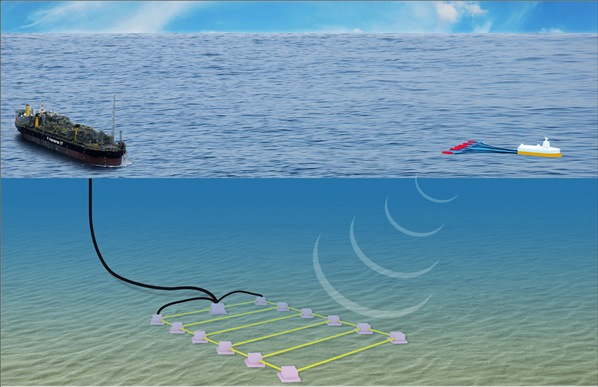

### 1.1 Sísmica da reflexão

O método sísmica da reflexão é o principal método da geofísica aplicada, no caso específico de exploração e caracterização de reservatórios de hidrocarbonetos (petróleo e gás natural), no sentido de que é recebido maiores investimentos por parte da indústria do petróleo. Em uma aquisição típica de sísmica de reflexão, uma fonte de ondas sísmicas é aplicada (usualmente próxima à superfície, em terra ou em mar), de forma que essa pertubação gera uma onda mecânica que se propaga no interior da área de interesse, ou seja, é gerado um sismo artificial de magnitude pequena. Quando encontra descontinuidades, em outras palavras, interfaces de transição entre duas geologias distintas, a onda gerada pela fonte é divida em duas partes. Uma parte é refletida, com intensidade proporcional ao contraste de impedância acústica, e se dirige em direção à superfície, como ilustra a figura de esquerda. No momento em que a onda chega na superfície, a variação do campo de pressão é registrada pelos receptores, como podemos observar na figura a direita. A outra parte é refratada e segue no novo meio com uma velocidade diferente. Consequentemente, encontra novas interfaces e o processo descrito se repete.

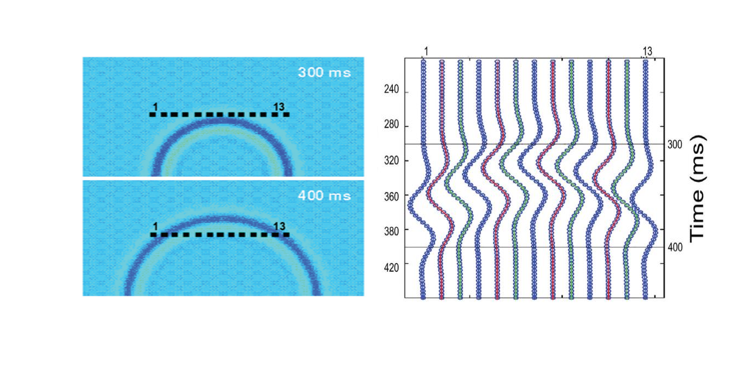

As múltiplas frentes de onda recorrentes das diversas reflexões que ocorrem no espaço e em um dado intervalo de tempo, chamado de tempo de aquisição, são registradas nos receptores para posteriormente serem processadas e transformada em informação útil, como, por exemplo: um modelo de velocidade com base em um mapa de cores para a identificação de fontes de hidrocarbonetos. A fonte é detonada diversas vezes, varrendo, desta forma, imensas áreas e coletando grandes volumes de dados. A geometria de disposição das fontes e dos receptores influencia diretamente na qualidade final da imagem que poderá ser obtida. Outro aspecto fundamental é a redundância de informações, que possibilitará, no final das contas, aumentar a razão sinal-ruído e extrair informações sobre as velocidades de propagação do meio.

### 1.2 Modelagem sísmica

A modelagem sísmica é uma disciplina essencial no vasto campo da geofísica, desempenhando um papel crucial na compreensão das complexidades do subsolo terrestre. Utilizando princípios fundamentais da física das ondas, a modelagem sísmica visa recriar e analisar o comportamento das ondas sísmicas à medida que atravessam as diferentes camadas geológicas. Esta abordagem não apenas fornece insights valiosos sobre a estrutura subsuperficial da Terra, mas também desempenha um papel vital em diversas aplicações, desde a exploração de recursos naturais até estudos geotécnicos para avaliação de riscos sísmicos. Nesta jornada pela modelagem sísmica, exploraremos os princípios subjacentes, os métodos avançados empregados e as aplicações práticas que fazem desta disciplina uma ferramenta indispensável para cientistas, engenheiros e profissionais envolvidos na compreensão e utilização dos recursos geológicos do nosso planeta.

## 2. Física da propagação acústica da onda

****

A presente exposição aborda a teoria relacionada à disseminação de ondas sonoras. A abordagem acústica afirma que os efeitos de cisalhamento nos dados podem ser considerados insignificantes, e que o tipo preponderante de onda é a onda compressional, ou onda do tipo P, caracterizada pelo movimento das partículas em paralelo à direção de propagação. Para aprofundar nosso entendimento dessa abordagem acústica, fornecemos uma síntese sobre a física subjacente à equação das ondas acústicas. Recomenda-se a consulta a obras de referência como Kinlser e Frey (1961) para uma compreensão mais aprofundada.

### 2.1 Equação da onda acústica

Para encontar a equação da onda acústica, vamos partir de duas equações bem estabelecidas nos estudos gerais da elastodinâmica, as equações 1 e 2 abaixo. Não faremos, nessa material, a dedução dessas equações,pois faremos isso em um próximo Notebook, onde estudaremos um pouco sobre a modelagem elástica. Contudo, as duas equações são aplicações diretas da segunda Lei de Newton da Lei Hooke.

$$\tag{1} \frac{\partial v_i(\vec{x}, t)}{\partial t} - \frac{1}{\rho(\vec{x})}\frac{\partial \tau_{ij}}{\partial x_j} = F_i(\vec{x}, t)$$

$$ \tag{2} \frac{\partial \tau_{ij}(\vec{x}, t)}{\partial t} - c_{ijpq}(\vec{x})\frac{\partial v_q(\vec{x}, t)}{\partial x_p} = I_{ij}(\vec{x}, t)$$

Note que estamos usando a convenção da soma de Eisntein, para facilitar nossa anotação.

Agora, vamos fazer algumas considerações. Se o meio é acústico, isso significa que efeito de cisalhamento são insignificantes. De modo que podemos impor que o tensão de tenção $\tau_{ij}$ só tem componentes matricial ao longo da sua diagonal principal, ou seja, $\tau_{ij} = -P\delta_{ij}$, onde $P$ é o escalar pressão. De maneira geral, podemos assumir que $I_{ij} = Ki_{v}\delta_{ij}$, e $c_{ijpq} = K\delta_{ij}\delta_{pq}$, onde $K$ é conhecido como módulo de Bulk, $i_v$ é a densidade de volume da injeção de volume. Partindo desses afirmações, temos que

$$\tag{3} \rho(\vec{x})\frac{\partial v_k(\vec{x}, t)}{\partial t} + \frac{\partial P(\vec{x}, t)}{\partial x_k} = F_k(\vec{x}, t),$$

$$ \tag{4} \frac{\partial P(\vec{x}, t)}{\partial t} +  K(\vec{x})\frac{\partial v_i(\vec{x}, t)}{\partial x_i} = K(\vec{x})\frac{\partial i_v(\vec{x}, t)}{\partial x_i}.$$

Sabemos,a partir de considerações termodinâmicas que a compressibilidade $k$ pode ser definida como $k= \frac{1}{K}$ **[4]**. Note também que tomando a derivada da equação 3 em relação a $x_{k}$ e substituindo essa equação na Lei de Hooke (Equação 4) vamos obter a seguinte expressão

$$ \tag{5} k(\vec{x})\frac{\partial ^2P}{\partial t^2} - \frac{\partial}{\partial x_{k}}\left(\frac{1}{\rho(\vec{x})}\frac{\partial P}{\partial x_k}\right) = \frac{\partial ^2}{\partial x_k^2}\left(\frac{F_k}{\rho(\vec{x})}\right) + \frac{\partial ^2 i_v}{\partial t^2}.$$

Saindo da convenção da soma de Einstein, podemos reescrever a equação acima como

$$ \tag{6} \left[k(\vec{x})\frac{\partial ^2}{\partial t^2} - \vec{\nabla} \cdot \left(\frac{1}{\rho(\vec{x})} \vec{\nabla}\right)\right]P = -\vec{\nabla} \cdot \left(\frac{\vec{F}}{\rho(\vec{x})}\right) + \frac{\partial ^2 i_v}{\partial t^2}.$$

Para casos, onde podemos assumir que $\rho$ é constante, ou casos onde o grandiente de $\rho$ pode ser desprezado, a equação 6 torna-se

$$ \tag{7} \frac{1}{c_p^2}\frac{\partial ^2P}{\partial t^2} - \nabla^2P = -s(t),$$

onde $c_p = c_p(\vec{x}) = 1/\sqrt{\rho(\vec{x}) k(\vec{x})}$ é a velocidade da onda acústica e $s(t) = \vec{\nabla}\vec{F} - \rho(\vec{x})\partial ^2 i_v / \partial t^2$ é conhecido como termo fonte. Assim, a equação 7 é a expressão final que rege a evolução espacial e temporal do campo de pressão para uma onda acústica. Em regiões onde o gradiente de densidade não seja desprezível, esta equação não é uma boa aproximação. Um caso típico onde isto ocorre é no fundo do mar, quando a onda passa da água para as primeiras camadas de sedimentos. Neste caso, embora, a princípio, a direção de propagação e os tempos de trânsito sejam bem descritos pela equação, o mesmo não se verifica com a amplitude. No jargão da área honra a cinemática da propagação, mas não a dinâmica.

### 2.5 Assinatura sísmica (Função fonte de Ricker)

Em linhas gerais, uma fonte sísmica refere-se a qualquer dispositivo utilizado para produzir ondas sísmicas que se propagarão através do meio a ser investigado. Exemplos de possíveis fontes sísmicas em levantamentos geofísicos terrestres incluem a explosão de explosivos enterrados, o lançamento de pesos e o uso de veículos vibratórios. No contexto de levantamentos em ambientes marítimos, em geral, a fonte primária é um canhão de ar comprimido (airgun). Esse processo de injeção de ar ocorre durante um curto período de tempo, normalmente da ordem de uma fração de segundo (o que resulta em frequências típicas de algumas dezenas de Hertz). Isso gera uma frente de onda esférica que se propaga pela água até atingir as primeiras camadas de rocha no leito oceânico e continua a se propagar pelas formações rochosas subterrâneas. Ao encontrar regiões com variações significativas nas propriedades físicas (contrastes de impedância), ocorrem reflexões, refrações e difrações, parte dessa energia é refletida de volta à superfície, onde pode ser detectada por hidrofones. A onda produzida por um airgun é do tipo P, ou seja, puramente longitudinal, sendo o único tipo de onda que se propaga em fluidos (como é o caso da água). No entanto, isso não significa que não existam ondas S em levantamentos marítimos, pois ocorre a conversão da onda P gerada pela fonte em onda S ao atingir as primeiras camadas de rocha na subsuperfície. No entanto, neste estudo, apenas as ondas P serão analisadas, pois a teoria acústica é empregada com esse foco.

É desejável que a fonte possua certas características específicas. Primeiramente, é fundamental que ela apresente um espectro definido, no qual se observe a presença de uma frequência máxima. Em segundo lugar, é necessário que a fonte tenha uma frequência apropriada para detectar as características na escala de interesse, além de permitir a propagação da onda por distâncias da ordem de alguns quilômetros. No formalismo adotado neste estudo, uma fonte é caracterizada pela distribuição de densidade de força (forças de volume) e pelo parâmetro de injeção de massa $i_v$. Como é convencional na geofísica, será utilizada uma fonte modelada pelo pulso de Ricker, que corresponde a uma injeção de massa gaussiana, como será detalhado adiante. O termo "fonte" mencionado na Equação 10 é expresso pela seguinte função

$$\tag{8} s(t) = [2\pi^3(f_ct_d)^2 -1]e^{- [\pi^3(f_ct_d)^2]}$$

na qual $f_c$ é um parâmetro relacionado à frequência de corte $f_{corte}$ e $t_d$ é o tempo defasado usado para deslocar o início da aplicação da fonte. Isso é feito de modo que o máximo (ou mínimo, conforme o caso) da função seja deslocado de zero para um tempo $t_0$ positivo, de forma que a expressão seja praticamente nula no início da análise (em $t_0 = 0$) e cresça suavemente (sem descontinuidades), como ilustrado na Figura 3. As expressões para os parâmetros mencionados são fornecidas a seguir.

$$\tag{9} f_c = \frac{f_{corte}}{3\sqrt{\pi}}$$

$$\tag{10} t_d = t - t_0$$

$$\tag{11} t_0 = \frac{2\sqrt{\pi}}{f_{corte}}$$

## 3. Implementação computacional

***

Para nosso implementação computacional, vamos considerar uma propagação acústica 2D. Assim, a equação 7 pode ser escrita como

$$ \tag{12} \left[\frac{\partial ^2P(x,z,t)}{\partial z^2} + \frac{\partial ^2P(x,z,t)}{\partial x^2}\right] - \frac{1}{c_p(x,z)}\frac{\partial ^2P(x,z,t)}{\partial t^2} = s(x,z,t).$$

Para computar nosso solução numérica, vamos usar o método das diferenças centradas.

### 3.1 Método das diferenças centradas

O método das diferenças centradas consiste em aproximar a derivada de segunda ordem em torno de um dado ponto tomando o valor do ponto sucessor e antecessor para calcular o valor da derivadas nesse ponto. Dado $i$ como sendo o passo espacial da direção $x$, $j$ o passo na direção $z$ e $n$ o passo de evolução temporal, as derivadas na equação da onda cústica podem ser aproximadas da seguinte forma

$$
\tag{13} \frac{∂^2P}{∂x^2} \approx  \frac{∂}{∂x}\left(\frac{P^{n}_{j,i+1} - P^n_{j,i}}{\Delta x}\right) = \frac{∂}{∂x}\left(\frac{P^n_{j,i+1}}{\Delta x}\right) - \frac{∂}{∂x}\left(\frac{P^{n}_{j,i-1}}{\Delta x}\right) = \frac{P^n_{j,i+1} -2P^n_{j,i} + P^{n}_{j,i-1}} {\Delta x^2},
$$

$$ \tag{14}
\frac{∂^2P}{∂z^2} \approx  \frac{∂}{∂z}\left(\frac{P^{n}_{j,+1i} - P^n_{j,i}}{\Delta z}\right) = \frac{∂}{∂z}\left(\frac{P^n_{j+1,i}}{\Delta z}\right) - \frac{∂}{∂z}\left(\frac{P^{n}_{j-1,i}}{\Delta z}\right) = \frac{P^n_{j+1,i} -2P^n_{j,i} + P^{n}_{j-1,i}} {\Delta z^2},
$$

$$\tag{15}
\frac{∂^2P}{∂t^2} \approx  \frac{∂}{∂t}\left(\frac{P^{n+1}_{j,i} - P^n_{j,i}}{\Delta t}\right) = \frac{∂}{∂t}\left(\frac{P^{n+1}_{j,i}}{\Delta t}\right) - \frac{∂}{∂t}\left(\frac{P^{n}_{j,i}}{\Delta t}\right) = \frac{P^{n+1}_{j,i} -2P^n_{j,i} + P^{n-1}_{j,i}} {\Delta t^2}.
$$

Substituindo as equações 13, 14 e 15 na equação 12 da onda acústica e reorganizando os termos, temos

$$ \tag{16}
P^{n+1}_{j,i}= 2P^{n}_{j,i} - P^{n-1}_{j,i} + \frac{c_p^2\Delta t^2}{\Delta z^2}\left( P^{n}_{j+1,i} - 2P^{n}_{j,i} + P^{n}_{j-1,i}\right) + \frac{c_p^2\Delta t^2}{\Delta x^2}\left( P^{n}_{j,i+1} - 2P^{n}_{j,i} + P^{n}_{j,i-1}\right) + s^{n}_{j,i}.
$$

Essa é a equação que usaremos para fazer a propagação 2D do campo de pressão da onda acústica. é interessante notar que que podemos expandir essa derivada de segunda ordem em série de taylor e assim obter uma oproximação com mais pontos. Ao invés de 3, podemos expandir essa derivada em 5 pontos. Contudo, neste material usaremos somente a aproximação de 3 pontos. Para consultar como compilar a segunda opção segue o link : [W4_fd_ac2d_homogeneous.ipynb](https://github.com/heinerigel/coursera/blob/master/Notebooks4Coursera/W4/W4_fd_ac2d_homogeneous.ipynb).

#### 3.1.1 Critério de estabilidade

O critério de estabilidade para evitar a dispersão númerica para a propagção 2D é dado pela equação abaixo **[2]**.

$$\tag{17} \epsilon = c_p\frac{dt}{dx} \leq \frac{1}{\sqrt{2}}$$

#### 3.1.2 Modelagem 2D de meio homogênio

Nosso primeiro passo será definir a função fonte da nossa propagação.

In [3]:
def ricker_pulse(f_corte, t):
    
    f_c = f_corte/(3*np.sqrt(np.pi))
    t_0 = (2*np.sqrt(np.pi))/f_corte
    t_d = t - t_0
    
    src = -(2*np.pi**3*(f_c*t_d)**2 -1)*np.exp(-(np.pi**3*(f_c*t_d)**2))
    return src

Agora, vamos criar o modelo geológico de velocidades. Para fins didáticos, vamos criar um modelo bem simples, no qual o meio é homogênio e a fonte é pontual. Mas antes, vamos definir algumas variáveis importantes.

In [4]:
nx  = 400 # Número de pontos da grade na direção x
nz  = 400  # Número de pontos da grade na direção z
dx  = 5  # Distância dos pontos do grade na direção x
dz  = dx  # Distância dos pontos do grade na direção z
snap1 = 50  # tempo do primeiro snapshot = snap1*dt
snapRate = 25 # tempo entre snapshots = snapRate*dt
c0 = 1700 # Velocidade de propagação (m/s)
isx = 200 # Lozalização x da fonte
isz = 200   # Lacalização z da fonte
nt  = 1500   # Número máximo de passos de tempo
dt  = 0.0005  # Passo de tempo
f_corte = 50 # frequência de corte

# Inicializando a grade
x    = np.arange(nx)
x    = x * dx    # Coordenada x
z    = np.arange(nz)
z    = z * dz   # Coordenada z

Criando o modelo homogênio de velocidade.

In [5]:
# Inicializando o modelo de velocidade

cp = np.zeros((nz, nx))
cp += c0
cmax = np.max(cp)

Computando a função fonte.

In [6]:
# Função fonte (Ricker Pulse)
# -------------------------------
time = np.linspace(0 * dt, nt * dt, nt)
src = ricker_pulse(f_corte, time)

Plotando o Pulso de Ricker de frequência corte igual $50 Hz$ e seus respectivo espectro de frequência.

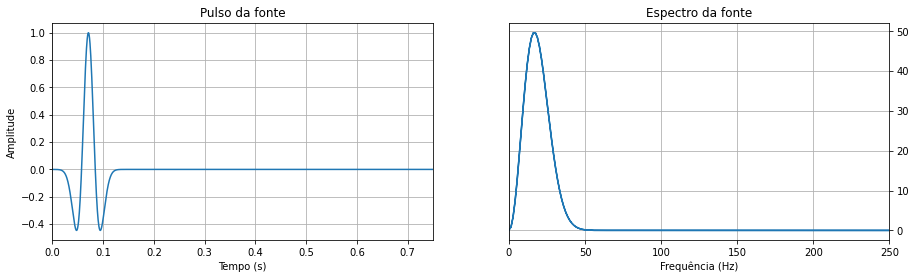

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(time, src) # plot source time function
ax[0].set_title('Pulso da fonte')
ax[0].set_xlim(time[0], time[-1])
ax[0].set_xlabel('Tempo (s)')
ax[0].set_ylabel('Amplitude')
ax[0].yaxis.tick_left()
ax[0].yaxis.set_label_position("left")
ax[0].grid(True) 

spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt) # time domain to frequency domain
ax[1].plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax[1].set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax[1].set_title('Espectro da fonte')
ax[1].set_xlabel('Frequência (Hz)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].grid(True) 
plt.show()

Verificando o critério de estabilidade.

In [8]:
# Critério de estabilidade CFL 
# -----------------------
eps  = cmax* dt / dx
print('Citério de estabilidade =', eps)

Citério de estabilidade = 0.16999999999999998


In [9]:
# Incializando as condições iniciais do campo de pressão e suas derivadas
# -------------------------
p    = np.zeros((nz, nx)) # p at time n (now)
pold = np.zeros((nz, nx)) # p at time n-1 (past)
pnew = np.zeros((nz, nx)) # p at time n+1 (present)
d2px = np.zeros((nz, nx)) # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx)) # 2nd space derivative of p in z-direction

snapTimes = np.arange(snap1, nt, snapRate)
pSnap = np.zeros((nz, nx, len(snapTimes)))

# Propagação acústica 2D
# -------------------------
with tqdm(total=nt) as progressing_load:
    for it in range(nt):
        for i in range(1, nz - 1):
                d2pz[i,:] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) 
        for j in range(1, nx - 1):
                d2px[:,j] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1])

        d2px /= dx ** 2
        d2pz /= dx ** 2
        
        # Evolução temporal
        # ------------------
        pnew = 2 * p - pold + (cp ** 2) * (dt ** 2) * (d2pz + d2px)

        # Adicionando a fonte
        # -------------------------
        pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2) 
        pnew[0,:] = 0.

        # Atualizando as variáveis
        # -----------------
        pold, p = p, pnew

        # Guardando frames do campo de pressão
        # -------------------------
        if it in snapTimes:
            snapIdx = np.where(snapTimes == it)[0][0]
            pSnap[:, :, snapIdx] = p

        # Update Data for Wave Propagation Plot
        # -------------------------
        progressing_load.update(1)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:25<00:00, 59.66it/s]


Para visualizar a propagação da onda vamos computar o seguinte código.

MovieWriter ffmpeg unavailable; using Pillow instead.


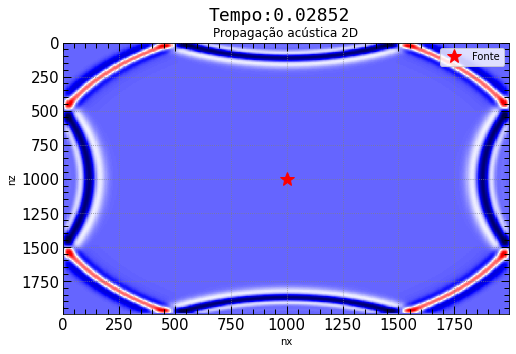

In [10]:
fig, ax = plt.subplots(1,figsize = (8, 5))

ax.set_title('Propagação acústica 2D')
leg1, = ax.plot(isx*dx, isz*dz, 'r*', markersize=15)
ax.set_xlabel('nx')
ax.set_ylabel('nz')
ax.legend((leg1,), ('Fonte',), loc='upper right', fontsize=10, numpoints=1)

def update(i):
    plt.suptitle(f'Tempo:{round(time[i],5)}')
    ax.imshow(pSnap[:,:,i], extent=[x[0],x[nx-1],z[nz-1],z[0]],vmax=np.max(pSnap[:,:,15]), vmin=np.min(pSnap[:,:,15]), 
              interpolation="nearest", aspect='auto', origin='upper', cmap='seismic')
    
ani = animation.FuncAnimation(fig, update, pSnap.shape[2], interval = 100, repeat = False, cache_frame_data = False)
opt_plot()
ani.save('Propagação-homogênea.gif')
plt.show()

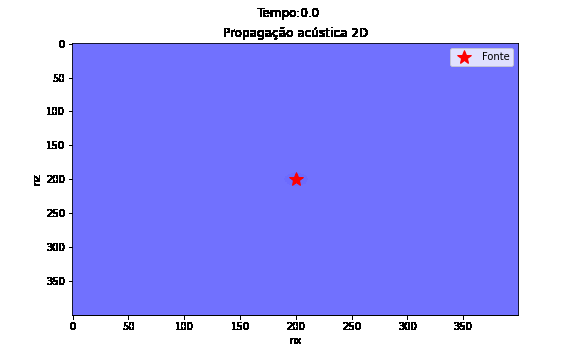

### 3.2 Condições de absorção de borda

No contexto sísmico, Aplicar $p = 0$ em todos os bordss do domínio numérico não é adequado, uma vez que isto faz com que toda a onda incidente sobre as interfaces seja refletida. Apenas o topo do modelo deveria ter este comportamento, uma vez que se trata da superfície do mar nas simulações aqui realizadas. Nos demais bordos (nas laterais e na borda inferior), deve-se recorrer a estratégias especiais, chamadas de condições de contorno não-reflexivas, para que as ondas que as atinjam sejam atenuadas e não gerem artefatos numéricos em virtude do truncamento do domínio físico em um domínio computacional de dimensões adequadas. Dito de outra forma, a necessidade de utilização de condições de contorno nãoo-reflexivas se deve ao fato de os problemas que se deseja modelar serem na verdade problemas de domínios semi-infinitos, onde as bordas laterais e inferior devem ser simuladas como “transparentes”, evitando a degradação das soluções pelas reflexões nas bordas numéricas.

#### 3.2.2 Modelagem 2D de meio homogênio com absorção na teoria das ondas unidirecionais

Uma estratégia simples é mudar a equação da onda 2D pela equação unilateral da onda (*one-way equation*) nas bordas de interesse. Nesse sentido, podemos escrever a equação unidimensional da onda da seguinte forma

$$ \tag{18} \frac{\partial^2 P}{\partial x^2} - \frac{1}{c_p^2}\frac{\partial^2 P}{\partial t^2} = \left(\frac{\partial}{\partial x} + \frac{1}{c_p}\frac{\partial}{\partial t}\right)\left(\frac{\partial}{\partial x} - \frac{1}{c_p}\frac{\partial }{\partial t}\right)P = 0,$$

onde identificamos cada um dos operadores diferenciais como responsável por fazer a onda pra pagar para cada um dos sentidos (direita ou esquerda), que dão origem a solução completa da equação da onda, a conhecida solução de D’Alembert. A partir da fatoração acima, podemos escrever as equações unidirecionais da onda

$$ \tag{19} \frac{\partial P}{\partial x} + \frac{1}{c_p}\frac{\partial P}{\partial t} = 0,$$

$$\tag{20} \frac{\partial P}{\partial x} - \frac{1}{c_p}\frac{\partial P}{\partial t} = 0.$$

A segunda equação é aplicada nos pontos da borda esquerda, o que tem o efeito de reduzir a reflexão da onda que atinge esta borda enquanto se propaga no meio 2D. A primeira equação é aplicada na borda direita e uma equação similar para a componente $z$ é aplicada na borda inferior. A ideia é aplicar a equação unidimensional da onda nas extremidades das bordas, ou seja, para $i = 0$, $i = nx-1$ e $j = nz-1$, sendo $i$ a posição da grade no sentido de $x$ e $j$ no sentido de $z$. A aproximAção de primeira ordem por diferenças finitas para as duas equações são dadas abaixo.

$$ \tag{21} P^{t+1}_{j, nx-1} = P^{t}_{j, nx-1} - \frac{c_p \Delta t}{\Delta x}\left( P^{t}_{j, nx-1} - P^{t}_{j, nx-2}\right),$$

$$\tag{22}  P^{t+1}_{j, 0} = P^{t}_{j, 0} + \frac{c_p \Delta t}{\Delta x}\left( P^{t}_{j, 1} - P^{t}_{j, 0}\right),$$

$$\tag{23} P^{t+1}_{nz-1, i} = P^{t}_{nz-1, i} - \frac{c_p \Delta t}{\Delta z}\left( P^{t}_{nz-1, i} - P^{t}_{nz-1, i}\right).$$

Note que os índices das variáveis acima estão de acorda com a indexação da liguagem Pyhton. Para outras linguagem, como Julia, é necessária acrescer 1 nos índices.

In [11]:
# Incializando as condições iniciais do campo de pressão e suas derivadas
# -------------------------
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx)) 
d2px = np.zeros((nz, nx)) 
d2pz = np.zeros((nz, nx))
d1px = np.zeros((nz, nx)) 
d1pz = np.zeros((nz, nx))

snapTimes = np.arange(snap1, nt, snapRate)
pSnap = np.zeros((nz, nx, len(snapTimes)))

# Calculate Partial Derivatives
# -----------------------------

with tqdm(total=nt) as progressing_load:
    for it in range(nt):
        for i in range(1, nz - 1):
                d2pz[i,:] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) 
        for j in range(1, nx - 1):
                d2px[:,j] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1])
                    

        d2px /= dx ** 2
        d2pz /= dx ** 2
        
        # Evolução para a região fora do limte de absorção
        pnew  = 2*p - pold + (cp ** 2) * (dt ** 2) * (d2px + d2pz)
        
        # Aniquilador do pacote de onda - Base
        pnew[nz-1,:] = p[nz-1,:]  - cp[nz-1,:]*dt*(p[nz-1,:] - p[nz-2,:])/dz
        
        # Aniquilador do pacote de onda - Esquerda e direita
        pnew[:, 0] = p[:, 0] + cp[:,0]*dt*(p[:,1] - p[:,0])/dx
        pnew[:, nx-1] = p[:, nx-1]  - cp[:, nx-1]*dt*(p[:,nx-1] - p[:,nx-2])/dx

        # Adicionando o termo fonte
        pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2) 
        pnew[0,:] = 0.

        # Atualizando as variáveis
        pold, p = p, pnew

        # Guardando frames do campo de pressão e velocidade
        if it in snapTimes:
            snapIdx = np.where(snapTimes == it)[0][0]
            pSnap[:, :, snapIdx] = p
            
        progressing_load.update(1)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:24<00:00, 62.15it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


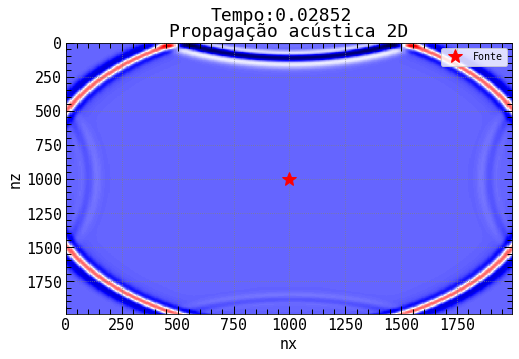

In [12]:
fig, ax = plt.subplots(1,figsize = (8, 5))

ax.set_title('Propagação acústica 2D')
leg1, = ax.plot(isx*dx, isz*dz, 'r*', markersize=15)
ax.set_xlabel('nx')
ax.set_ylabel('nz')
ax.legend((leg1,), ('Fonte',), loc='upper right', fontsize=10, numpoints=1)

def update(i):
    plt.suptitle(f'Tempo:{round(time[i],5)}')
    ax.imshow(pSnap[:,:,i], extent=[x[0],x[nx-1],z[nz-1],z[0]],vmax=np.max(pSnap[:,:,15]), vmin=np.min(pSnap[:,:,15]), 
              interpolation="nearest", aspect='auto', origin='upper', cmap='seismic')
    
ani = animation.FuncAnimation(fig, update, pSnap.shape[2], interval = 100, repeat = False, cache_frame_data = False)
opt_plot()
ani.save('Propagação-homogênea-com-absorção-de-borda-1.gif')
plt.show()

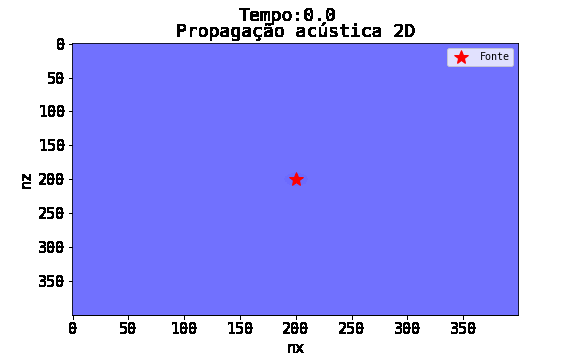

Observe que apesar da atenuação satisfatória do campo de pressão, ainda não temos um condição de borda reflexiva ideal para modelagem de dados mais acurados. Para melhorar nossas bordas de atenuação, vamos utilizar, combinado com a equação unidimensional, o que chamaos de condição de amortecimento de Cerjan.

#### 3.2.1 Absorção borda usando as condições de Cerjan e a teoria das onda unidirecionais

A condição de Cerjan, ou também conhecida como condição limite de amortecimento, é criada cercando o modelo numérico com uma faixa de grade, onde o campo de pressão é multiplicado por um fator $G(i)$ definido como

$$\tag{24} G(i) = e^{-\left[\frac{\alpha}{iabmax}(iabmax - i)\right]^2},$$

onde o $iabmax$ é o tamanho da grade de amortecimento e $\alpha$ é uma constante determinada por tentativa e erro. Para nossa implementação, usaremos $iabmax = 80$ e $\alpha = 0.1$.

In [13]:
# Coeficientes de Cerjan para as condições de borda
iabmax = 80
a0 = 0.1 / iabmax
eponge = np.zeros(iabmax + 1)
eponge[0:iabmax + 1] = np.exp(-(a0 * (iabmax - np.arange(iabmax + 1))) ** 2)

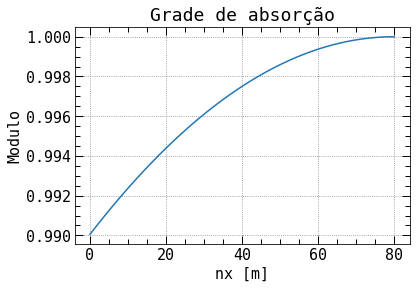

In [14]:
plt.plot(eponge)
plt.title('Grade de absorção')
plt.xlabel('nx [m]')
plt.ylabel('Modulo')
plt.grid()
opt_plot()
plt.show()

In [15]:
# Initialize Empty Pressure
# -------------------------
p = np.zeros((nz, nx)) # p at time n (now)
pold = np.zeros((nz, nx)) # p at time n-1 (past)
pnew = np.zeros((nz, nx)) # p at time n+1 (present)
d2px = np.zeros((nz, nx)) # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx)) # 2nd space derivative of p in z-direction
d1px = np.zeros((nz, nx)) # 2nd space derivative of p in x-direction
d1pz = np.zeros((nz, nx)) # 2nd space derivative of p in z-direction

snapTimes = np.arange(snap1, nt, snapRate)
pSnap = np.zeros((nz, nx, len(snapTimes)))

# Calculate Partial Derivatives
# -----------------------------

with tqdm(total=nt) as progressing_load:
    for it in range(nt):
        for i in range(1, nz - 1):
                d2pz[i,:] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) 
        for j in range(1, nx - 1):
                d2px[:,j] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1])

        d2px /= dx ** 2
        d2pz /= dx ** 2
        
        ia = np.arange(0, iabmax-1)
        ka = np.arange(0, iabmax-1)
        
        # Evolução para a região fora do limte de absorção
        pnew  = 2*p - pold + (cp ** 2) * (dt ** 2) * (d2px + d2pz)
        
        # Condição de absorção - Esquerda e direita
        for ia in range(0,iabmax):
            p[:, ia] = p[:, ia]*eponge[ia]
            pnew[:, ia] = pnew[:, ia]*eponge[ia]
            p[:, nx - 1 - ia] = p[:, nx - 1 - ia]*eponge[ia]
            pnew[:, nx - 1 - ia] = pnew[:, nx - 1 - ia]*eponge[ia]
        
        # Condição de absorção - Fundo
        for ka in range(0,iabmax):
            p[nz - ka - 1, :] = p[nz - ka - 1, :]*eponge[ka]
            pnew[nz - ka - 1, :] = pnew[nz - ka - 1, :]*eponge[ka]
        
        # Aniquilador do pacote de onda - Fundo
        pnew[nz-1,:] = p[nz-1,:]  - cp[nz-1,:]*dt*(p[nz-1,:] - p[nz-2,:])/dz
        
        # Aniqulidor do pacote de onda - Esquerda e direita
        pnew[:, 0] = p[:, 0] + cp[:,0]*dt*(p[:,1] - p[:,0])/dx
        pnew[:, nx-1] = p[:, nx-1]  - cp[:, nx-1]*dt*(p[:,nx-1] - p[:,nx-2])/dx

        # Adicionando o termo fonte
        pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2) 
        pnew[0,:] = 0.

        # Atualizando as variáveis
        pold, p = p, pnew

        # Guardando frames do campo de pressão e velocidade
        if it in snapTimes:
            snapIdx = np.where(snapTimes == it)[0][0]
            pSnap[:, :, snapIdx] = p
        
        progressing_load.update(1)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:32<00:00, 45.92it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


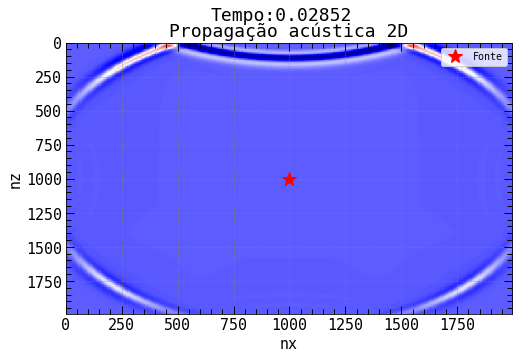

In [16]:
fig, ax = plt.subplots(1,figsize = (8, 5))

ax.set_title('Propagação acústica 2D')
leg1, = ax.plot(isx*dx, isz*dz, 'r*', markersize=15)
ax.set_xlabel('nx')
ax.set_ylabel('nz')
ax.legend((leg1,), ('Fonte',), loc='upper right', fontsize=10, numpoints=1)

def update(i):
    plt.suptitle(f'Tempo:{round(time[i],5)}')
    ax.imshow(pSnap[:,:,i],extent=[x[0],x[nx-1],z[nz-1],z[0]],vmax=np.max(pSnap[:,:,10]), vmin=np.min(pSnap[:,:,10]), 
              interpolation="nearest", aspect='auto', origin='upper', cmap='seismic')
    
ani = animation.FuncAnimation(fig, update, pSnap.shape[2], interval = 100, repeat = False, cache_frame_data = False)
opt_plot()
ani.save('Propagação-homogênea-com-absorção-de-borda-2.gif.gif')
plt.show()

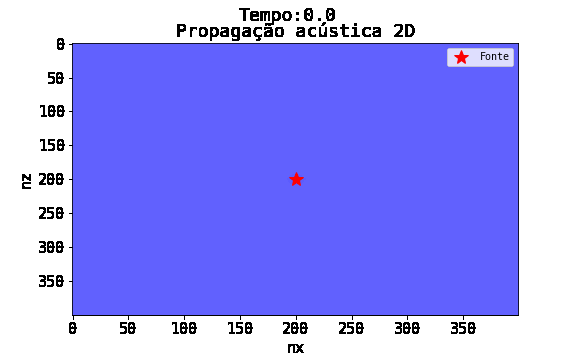

Agora sim, observamos um atenuação mais intensa do campo de pressão. Dado essas condições, podemos elaborar um modelo mais geológico mais complexo, onde temos várias interfaces de reflexão, em vitude das várias camadas de velocidade, ou seja, um modelo heterogênio.

### 3.2 Simulando um aquisição do tipo fonte comum (Comum Shot-Gather)

Para fazer nossa simulação, iremos usar um modelo de velocidade mais complexo, porém com menos pontos de grade. Para isso, bastar importar a imagem `subsurface.png`, que estará disponível junto a esse notebook, e usar a função definida abaixo.

In [17]:
def model(nx,nz,vp):
    
    imagem = cv2.imread(r'C:\Users\Matheus\Downloads\subsurface.png')
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    image_red = imagem[:,:,0]  # extract red channel
    
    for i in range(0,nx):
        for j in range(0,nz):
            
            # assume vaccum in the violet caves
            # if image_red[j,i]==128, set vp = 0 m/s
            vp[j,i] = 10.
            
            # if image_red[j,i]<50, set vp = 2000 m/s
            if(image_red[j,i]<112):
                vp[j,i] = 2000.
                
            # if image_red[j,i]>200, set vp = 3000 m/s
            if(image_red[j,i]>150):
                vp[j,i] = 2700.
                
    vp[:70,:] = 1200
                
    return vp

In [18]:
nx  = 400 # Número de pontos da grade na direção x
nz  = 400  # Número de pontos da grade na direção z
dx  = 5 # Distância dos pontos do grade na direção x
dz  = dx  # Distância dos pontos do grade na direção z

Nr = 400 # Número de receptores
isz = 20 # Posição z da fonte
isx = 200 # Posição x da fonte
irz = 70 # Posição z dos receptores
irx = np.linspace(0, nx, Nr) # Posição x dos receptores

snap1 = 50  # tempo do primeiro snapshot = snap1*dt
snapRate = 25 # tempo entre snapshots = snapRate*dt

nt = 2000   # Número máximo de passos de tempo
dt = 0.0008   # Passo de tempo
f_corte = 48 # frequência de corte

# Inicializando a grade
x    = np.arange(nx)
x    = x * dx    # Coordenada x
z    = np.arange(nz)
z    = z * dz   # Coordenada z

time = np.linspace(0 * dt, nt * dt, nt)

In [19]:
src = ricker_pulse(f_corte, time)

spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt)
num_onda = np.linspace(-(np.pi)/dx, (np.pi)/dx, nx)

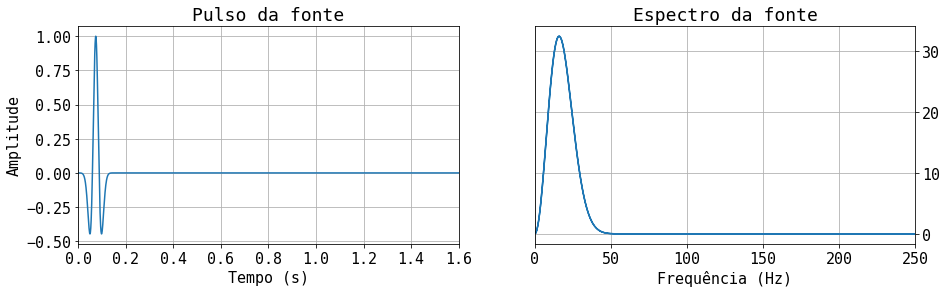

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(time, src) # plot source time function
ax[0].set_title('Pulso da fonte')
ax[0].set_xlim(time[0], time[-1])
ax[0].set_xlabel('Tempo (s)')
ax[0].set_ylabel('Amplitude')
ax[0].yaxis.tick_left()
ax[0].yaxis.set_label_position("left")
ax[0].grid(True) 

spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt) # time domain to frequency domain
ax[1].plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax[1].set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax[1].set_title('Espectro da fonte')
ax[1].set_xlabel('Frequência (Hz)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].grid(True) 
plt.show()

In [21]:
cp = np.ones((nz,nx))
cp = model(nx,nz,cp)
cmax = cp.max()

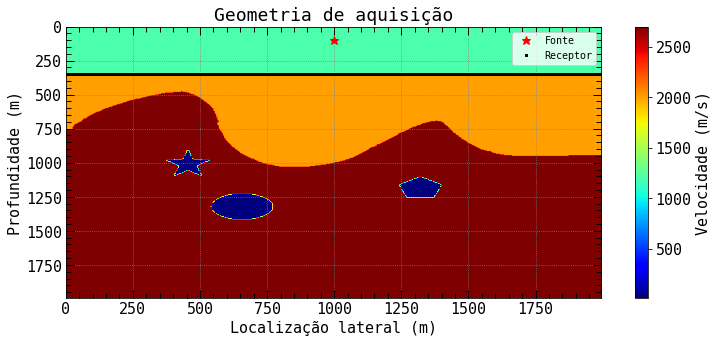

In [22]:
plt.figure(figsize=(12,5))
plt.title('Geometria de aquisição')
leg1, = plt.plot(isx*dx, isz*dz, 'r*', markersize=9) # plot da posição da fonte
leg2, = plt.plot(irx[0]*dx, irz*dz, 'ks', markersize=2)  
for i in range(1, Nr):
    plt.plot(irx[i]*dx, irz*dz, 'ks', markersize=2)
mc = plt.imshow(cp, extent=[x[0],x[nx-1],z[nz-1],z[0]], aspect='auto', origin='upper', cmap='jet')
plt.ylabel('Profundidade (m)')
plt.xlabel('Localização lateral (m)')
plt.legend((leg1, leg2), ('Fonte', 'Receptor'), loc='upper right', fontsize=10, numpoints=1)
plt.colorbar(mc, label='Velocidade (m/s)')
opt_plot()
plt.show()

In [23]:
# Critério de estabilidade CFL 
# -----------------------
eps  = cmax*dt / dx
print('Citério de estabilidade =', eps)

Citério de estabilidade = 0.43200000000000005


In [24]:
# Coeficientes de Cerjan para as condições de borda
iabmax = 90
a0 = 0.1 / iabmax
eponge = np.zeros(iabmax + 2)
eponge[0:iabmax + 1] = np.exp(-(a0 * (iabmax - np.arange(iabmax + 1))) ** 2)

In [25]:
# Incializando as condições iniciais do campo de pressão e suas derivadas
# -------------------------
p = np.zeros((nz, nx)) # p at time n (now)
pold = np.zeros((nz, nx)) # p at time n-1 (past)
pnew = np.zeros((nz, nx)) # p at time n+1 (present)
d2px = np.zeros((nz, nx)) # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx)) # 2nd space derivative of p in z-direction

snapTimes = np.arange(snap1, nt, snapRate)
pSnap = np.zeros((nz, nx, len(snapTimes)))

# Inicializando o sismograma
# ---------------------------
sismograma = np.zeros((nt, Nr), float)

# Propagação acústica 2D
# -------------------------

with tqdm(total=nt) as progressing_load:
    
    for it in range(nt):
        
        for i in range(1, nz - 1):
                d2pz[i,:] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) 
        for j in range(1, nx - 1):
                d2px[:,j] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1])

        d2px /= dx ** 2
        d2pz /= dx ** 2
        
        pnew = 2*p - pold + (cp ** 2) * (dt ** 2) * (d2px + d2pz)
        
        pnew[:, 0] = p[:, 0] + cp[:,0]*dt*(p[:,1] - p[:,0])/dx
        pnew[nz-1,:] = p[nz-1,:]  - cp[nz-1,:]*dt*(p[nz-1,:] - p[nz-2,:])/dz
        pnew[:, nx-1] = p[:, nx-1]  - cp[:, nx-1]*dt*(p[:,nx-1] - p[:,nx-2])/dx
        
        # Condição de absorção nas laterais
        for ia in range(0,iabmax):
            p[:, ia] = p[:, ia]*eponge[ia]
            pnew[:, ia] = pnew[:, ia]*eponge[ia]
            p[:, nx - 1 - ia] = p[:, nx - 1 - ia]*eponge[ia]
            pnew[:, nx - 1 - ia] = pnew[:, nx - 1 - ia]*eponge[ia]
        
        # Condição de absorção na fundo
        for ka in range(0,iabmax):
            p[nz - ka - 1, :] = p[nz - ka - 1, :]*eponge[ka]
            pnew[nz - ka - 1, :] = pnew[nz - ka - 1, :]*eponge[ka]

        pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2) 
        pnew[0,:] = 0.

        pold, p = p, pnew

        if it in snapTimes:
            snapIdx = np.where(snapTimes == it)[0][0]
            pSnap[:, :, snapIdx] = p
            
        for i in range(Nr-1):       
            sismograma[it, i] = p[irz, int(irx[i])]

        progressing_load.update(1)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:52<00:00, 37.80it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


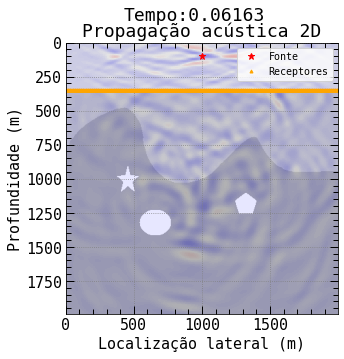

In [26]:
fig, ax = plt.subplots(1,figsize = (8, 5))

ax.set_title('Propagação acústica 2D')
leg1, = ax.plot(isx*dx, isz*dz, 'r*', markersize=7) # plot da posição da fonte
leg2, = ax.plot(irx[0]*dx, irz*dz, 'k^', markersize=3, color='orange')  
for i in range(1, Nr):
    ax.plot(irx[i]*dx, irz*dz, 'k^', markersize=3, color='orange')
ax.set_ylabel('nz')
ax.set_xlabel('nx')
ax.legend((leg1, leg2), ('Fonte', 'Receptores'), loc='upper right', fontsize=10, numpoints=1)
ax.set_ylabel('Profundidade (m)')
ax.set_xlabel('Localização lateral (m)')

def update(i):
    plt.suptitle(f'Tempo:{round(time[i],5)}')
    ax.imshow(pSnap[:, :, i], extent=[x[0],x[nx-1],z[nz-1],z[0]],interpolation="nearest", 
              aspect='auto', origin='upper', cmap='seismic',clim=(np.min(pSnap[:,:,15]), np.max(pSnap[:,:,15])))
    ax.imshow(cp,extent=[x[0],x[nx-1],z[nz-1],z[0]], cmap='Greys', alpha = 0.3)
    
ani = animation.FuncAnimation(fig, update, pSnap.shape[2] , interval = 100, repeat = True, cache_frame_data = False)
opt_plot()
ani.save('Propagação-heterogênea.gif')
plt.show()

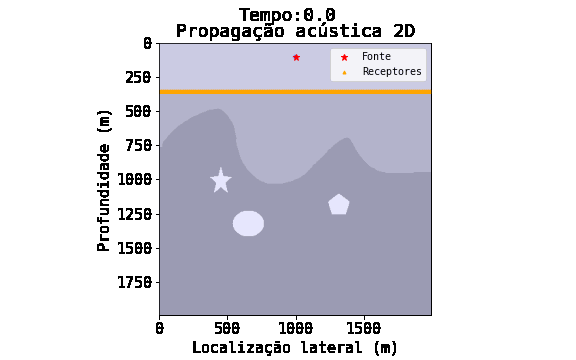

In [27]:
fk_domain = np.fft.fftshift(np.fft.fft2(sismograma, norm='ortho'), axes=-1).real

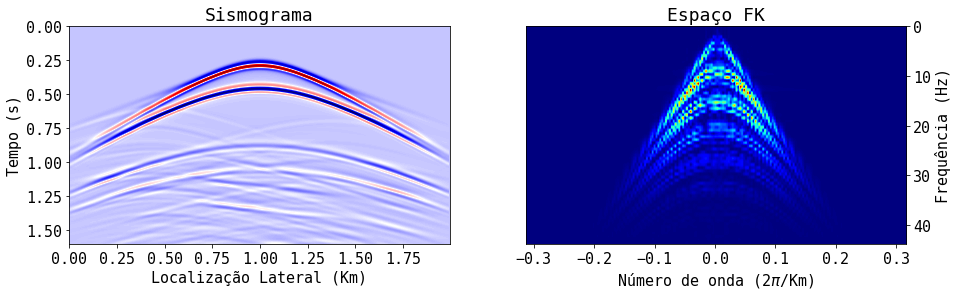

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].imshow(sismograma, extent=[x[0]/1000,x[nx-1]/1000,time[nt-1],time[0]],
           aspect='auto', origin='upper', cmap='seismic')
ax[0].set_title('Sismograma')
ax[0].set_ylabel('Tempo (s)')
ax[0].set_xlabel('Localização Lateral (Km)')
ax[0].yaxis.tick_left()
ax[0].yaxis.set_label_position("left")

ax[1].imshow(abs(fk_domain[0:70,100:300]),extent=[num_onda[100],num_onda[300],freq[70],freq[0]],
           aspect='auto', origin='upper', cmap='jet')
ax[1].set_title('Espaço FK')
ax[1].set_ylabel('Frequência (Hz)')
ax[1].set_xlabel('Número de onda (2$\pi$/Km)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
plt.show()

Observe que a frequência de corte do espaço F-K do nosso sismograma 2D é a mesma que da nossa wavelet.

## 4. Conclusão

****

A modelagem sísmica acústica é uma ferramenta crucial na exploração e produção de petróleo e gás, bem como em estudos geotécnicos e de engenharia civil. Ela permite aos geocientistas e engenheiros visualizarem e entenderem as características do subsolo, auxiliando na identificação de reservatórios de hidrocarbonetos. A modelagem acústica, ao considerar apenas a propagação das ondas sonoras, é mais rápida e computacionalmente menos intensiva, sendo frequentemente utilizada em estudos de exploração de hidrocarbonetos e em aplicações onde a precisão absoluta pode ser ligeiramente sacrificada em favor da eficiência computacional. Entretando, sua maior vantagem também é seu maior defeito, uma vez que consideramos somente a propagaçãa de onda do tipo P, a modelagem acústica não representa com exatidão característica de materiais rochosos, o que pode prejudicar em modelagem de dados do tipo OBN (Ocean Bottom Nodes). Em virtude disso, existem outras abordagem mais precisas e uma delas é a modelagem elástica que será discutida em um próximo notebook.

Caso tenha ficado interessado em realizar esse tipo de modelagem, mas não quer ter preocupação em computar o seguinte código, você pode usar a biblioteca *Devito* [01 - Introduction to seismic modelling
](https://slimgroup.github.io/Devito-Examples/tutorials/01_modelling/). Essa biblioteca faz a evolução das equações diferenciais de maneirta automática, sendo necessário definir somente os parâmetros do meio. Usando essa biblioteca é possível fazer tanto modelagem acústica quanto elástica.

## Referências

* **[1]** *Basic Principles of Wave Propagation, Gerard T. Schuster, 2011.* 

* **[2]** *Propagação de ondas aplicadas ao mapeamento geológico:formulação acustica, Leandro Di Bartolo, 2021.*

* **[3]** *MODELAGEM ACUSTICA BIDIMENSIONAL USANDO DIFERENTES PARAMETRIZACÕES DE CAMPOS DE VELOCIDADES, Roberto Hugo M. dos Santos, 2006.*

* **[4]** *Theory-of-seismic-waves-II - 2D acoustic FD modelling for heterogeneous media* [Theory-of-seismic-waves-II](https://github.com/daniel-koehn/Theory-of-seismic-waves-II/blob/master/05_2D_acoustic_FD_modelling/5_fdac2d_heterogeneous.ipynb)